**Importing Necessary Libraries**

In [36]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

**Support Vector Machines - Unbalanced Dataset**

In [ ]:
# 1. Load and prepare data
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
df.head()

In [38]:
df['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
6       1
10      1
12      1
Name: count, dtype: int64

In [39]:
df_filtered = df.query("target not in [4, 5, 10,6,12]")
df_filtered['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
Name: count, dtype: int64

In [40]:
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [41]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [42]:
# 3. Feature scaling (essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
svm = SVC(
    kernel='rbf',       
    C=1.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)

In [44]:
svm.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [45]:
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         3
           3       0.60      0.75      0.67        16
           7       0.00      0.00      0.00         2
           8       0.85      0.86      0.86        74
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.76       103
   macro avg       0.31      0.29      0.29       103
weighted avg       0.74      0.76      0.74       103


Confusion Matrix:


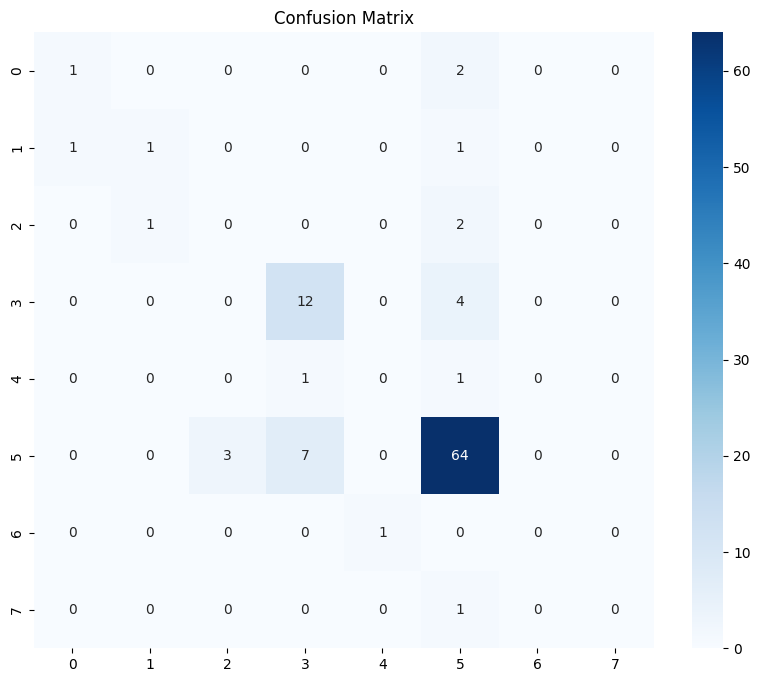

In [46]:
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [47]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.7573 (75.73%)


In [48]:
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

Class 0: Sensitivity = 0.3333, Specificity = 0.9900
Class 1: Sensitivity = 0.3333, Specificity = 0.9900
Class 2: Sensitivity = 0.0000, Specificity = 0.9700
Class 3: Sensitivity = 0.7500, Specificity = 0.9080
Class 4: Sensitivity = 0.0000, Specificity = 0.9901
Class 5: Sensitivity = 0.8649, Specificity = 0.6207
Class 6: Sensitivity = 0.0000, Specificity = 1.0000
Class 7: Sensitivity = 0.0000, Specificity = 1.0000


c:\Users\DARSHAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


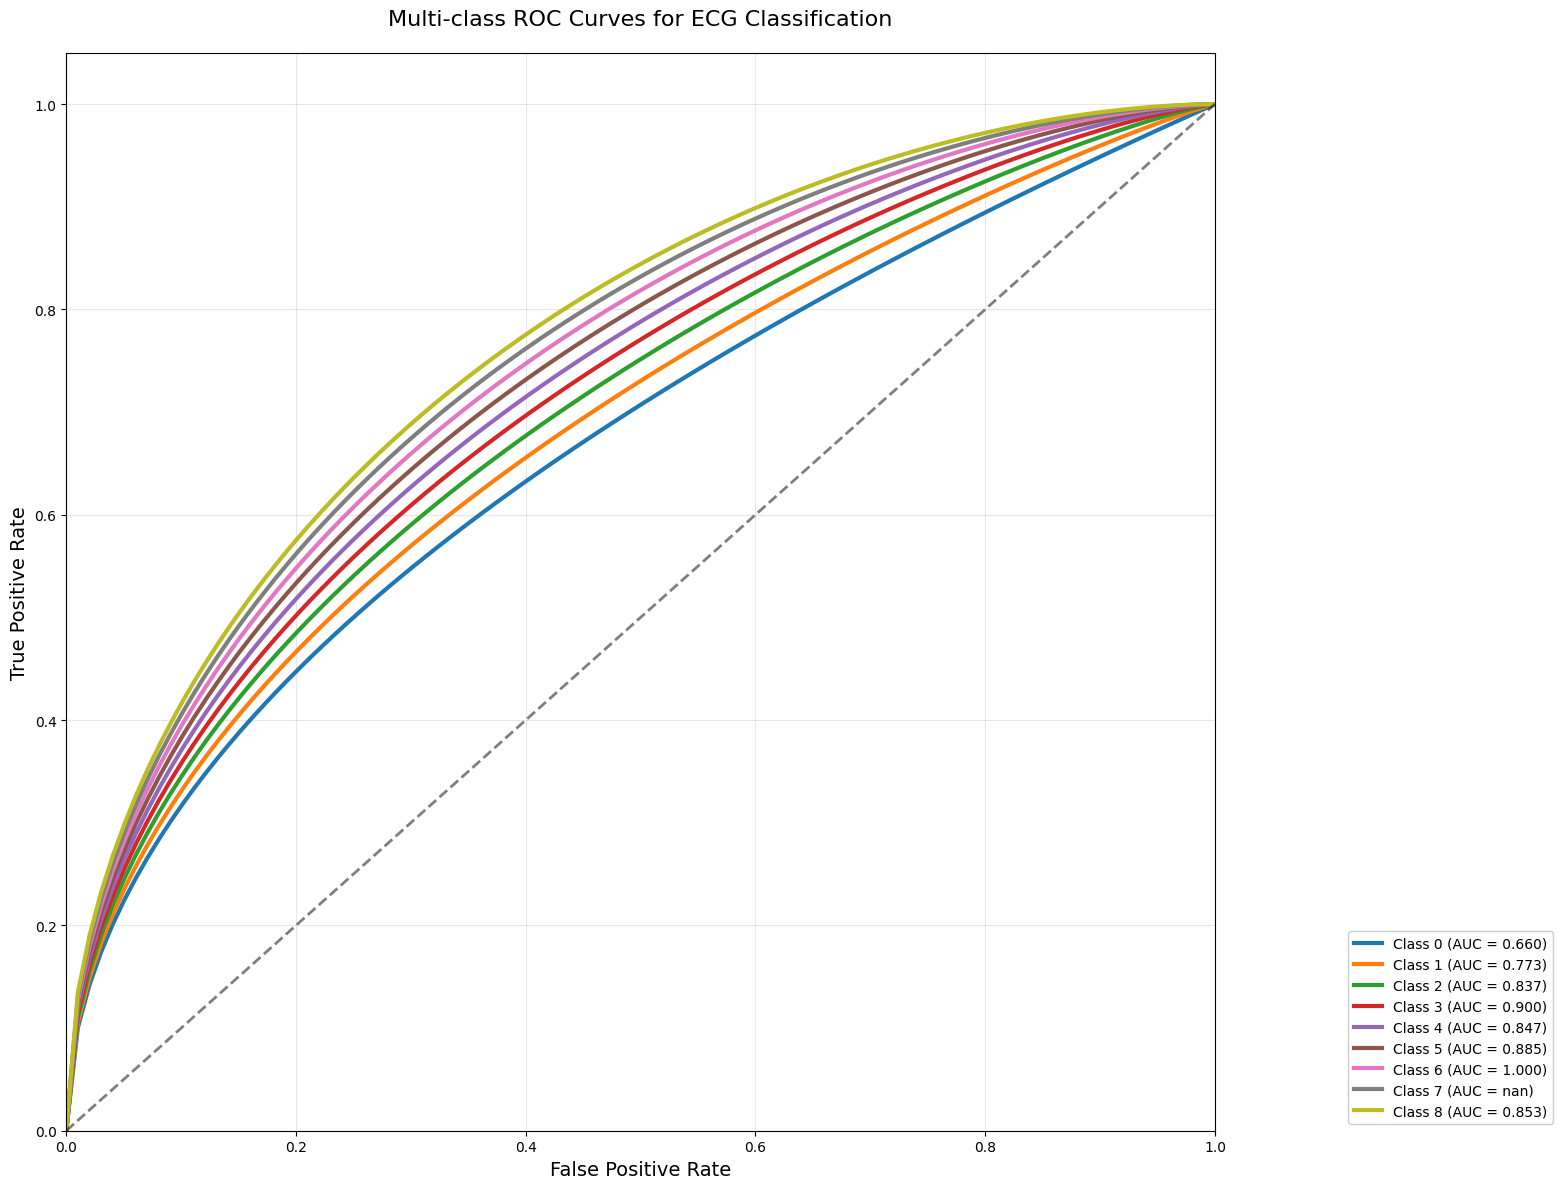

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Support Vector Machines - Balanced Dataset**

In [ ]:
df = pd.read_csv("../Datasets/Balanced_Multiclass.csv")
df.head()

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
svm = SVC(
    kernel='poly',       
    C=1.0,              
    gamma='scale',      
    class_weight='balanced', 
    probability=True,    
    random_state=42
)

In [54]:
svm.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', kernel='poly', probability=True, random_state=42)

In [55]:
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       1.00      0.99      0.99        73
           2       0.95      1.00      0.97        73
           3       0.97      1.00      0.99        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       0.99      1.00      0.99        74
           8       1.00      0.88      0.93        73
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00        74
          11       0.99      1.00      0.99        73
          12       1.00      1.00      1.00        73
          13       0.99      1.00      0.99        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028


C

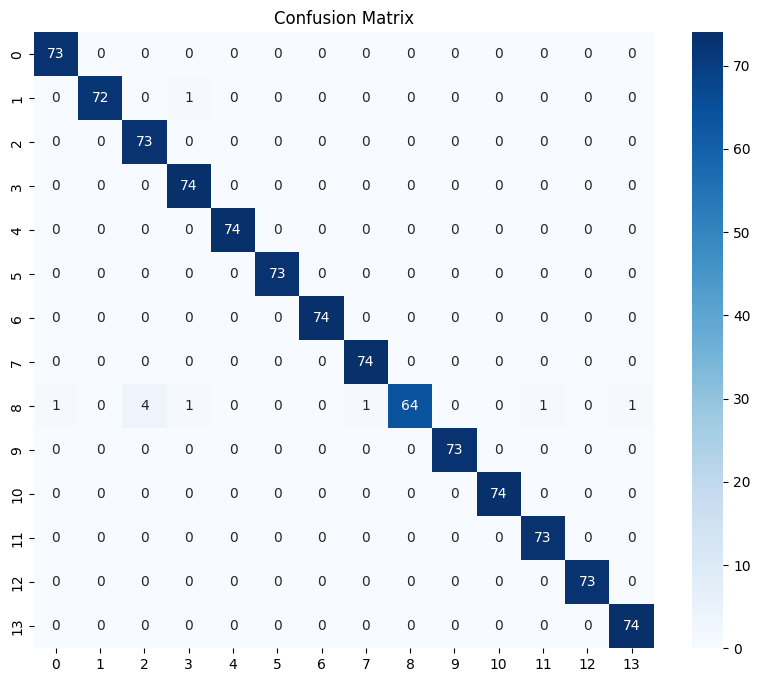

In [56]:
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [57]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.9903 (99.03%)


In [58]:
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")

Class 0: Sensitivity = 1.0000, Specificity = 0.9990
Class 1: Sensitivity = 0.9863, Specificity = 1.0000
Class 2: Sensitivity = 1.0000, Specificity = 0.9958
Class 3: Sensitivity = 1.0000, Specificity = 0.9979
Class 4: Sensitivity = 1.0000, Specificity = 1.0000
Class 5: Sensitivity = 1.0000, Specificity = 1.0000
Class 6: Sensitivity = 1.0000, Specificity = 1.0000
Class 7: Sensitivity = 1.0000, Specificity = 0.9990
Class 8: Sensitivity = 0.8767, Specificity = 1.0000
Class 9: Sensitivity = 1.0000, Specificity = 1.0000
Class 10: Sensitivity = 1.0000, Specificity = 1.0000
Class 11: Sensitivity = 1.0000, Specificity = 0.9990
Class 12: Sensitivity = 1.0000, Specificity = 1.0000
Class 13: Sensitivity = 1.0000, Specificity = 0.9990


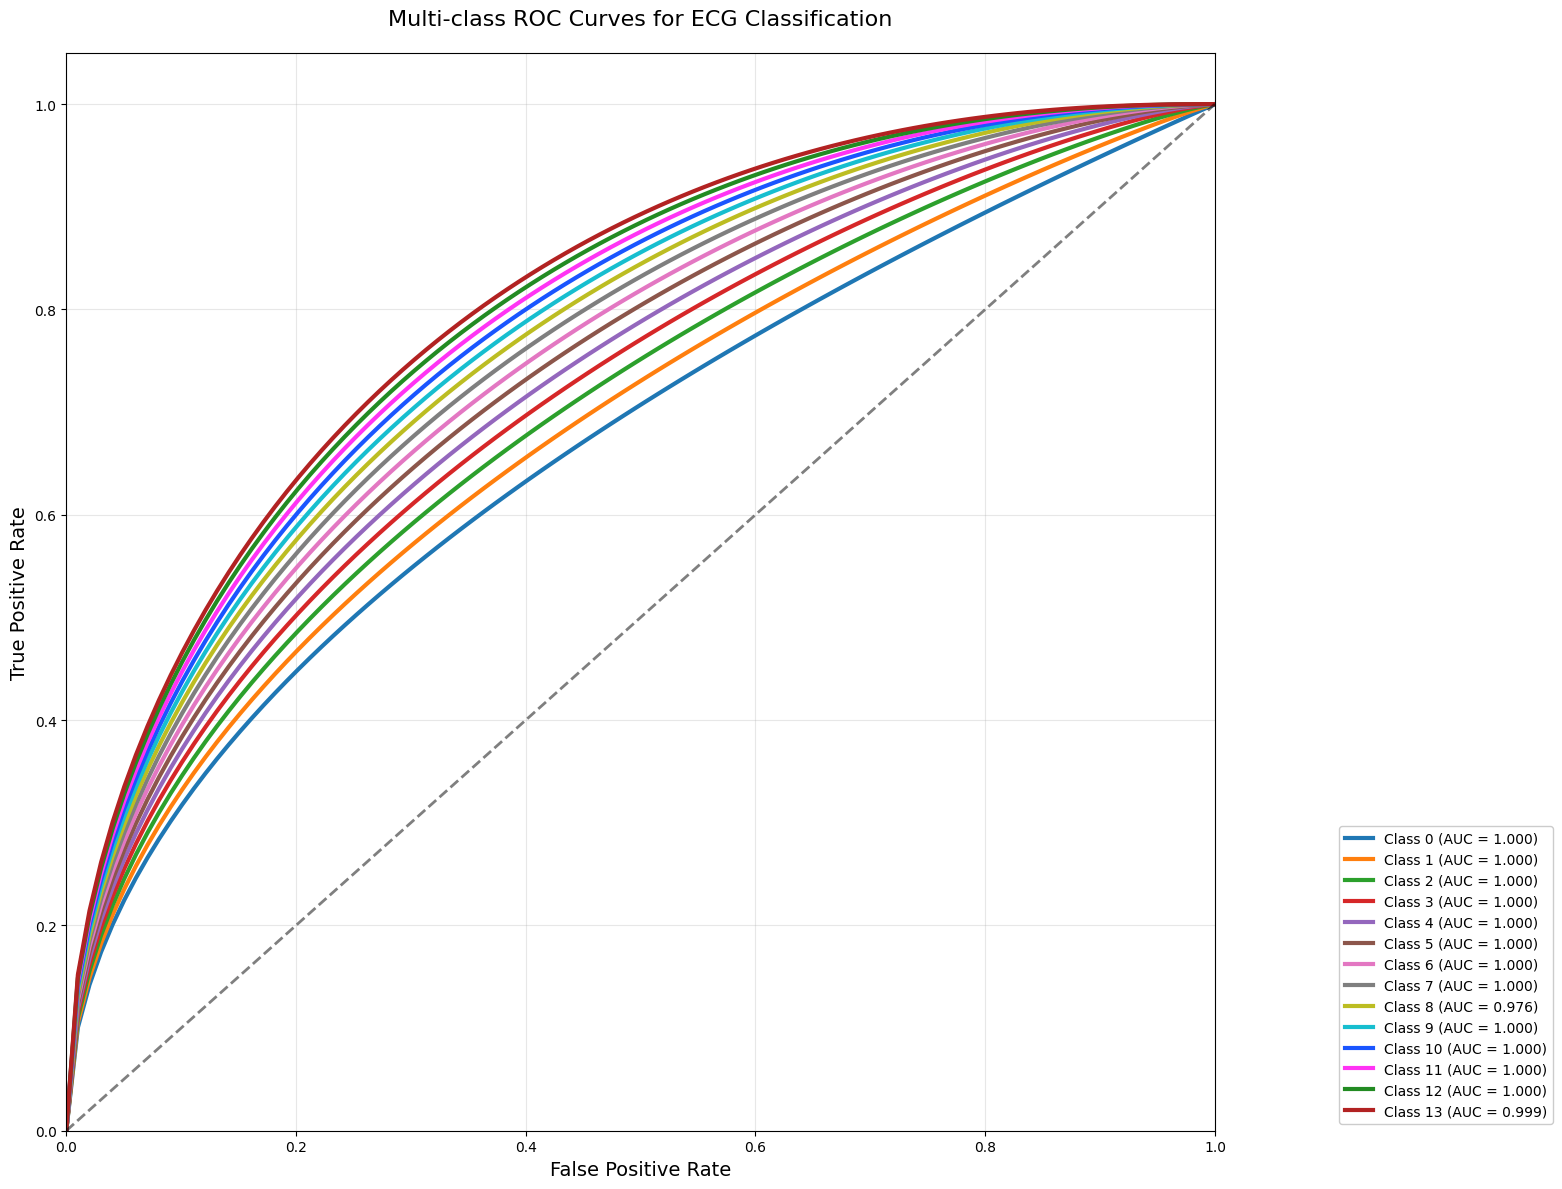

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()